In [39]:
from typing import Callable
import doctest

from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt

### Test functions

In [40]:
QUINTIC_SOLUTION = 1.1673039782614185

def quintic(x: float) -> float:
    return x ** 5 - x - 1


def quintic_derivative(x: float) -> float:
    return 5 * x ** 4 - 1


def quintic_hess(x: float) -> float:
    return 20 * x ** 3


def quartic(x: float) -> float:
    return x ** 4 + x ** 3 - 4 * x ** 2 + x + 1


def quartic_derivative(x: float) -> float:
    return 4 * x ** 3 + 3 * x ** 2 - 8 * x + 1
    

def quartic_hess(x: float) -> float:
    return 12 * x ** 2 + 6 * x - 8

### Minimisers

In [43]:
LITTLE_PHI = (5 ** 0.5 - 1) / 2


def relative_error(a: float | None, b: float | None):
    if None in (a, b):
        return np.inf
    return abs((b - a) / (b + a))


def newton(f, df, d2f, x0, tol, force_minimum=False):
    """
    >>> newton(quintic, quintic_derivative, quintic_hess, 1.0, tol=1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16)  #doctest: +ELLIPSIS
    -0.6687403...
    >>> newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16, force_minimum=True)  #doctest: +ELLIPSIS
    0.6687403...
    """
    x1 = None
    
    if force_minimum:
        d2f_ = d2f  # avoid namespace clash & recursion in lambda
        d2f = lambda x: np.abs(d2f_(x))

    while relative_error(x0, x1) > tol:
        x0 = x1 if x1 is not None else x0
        x1 = x0 - df(x0) / d2f(x0)
    return x1


def secant(f, df, x0, x1, tol):
    """
    >>> secant(quintic, quintic_derivative, 1.0, 1.1, tol=1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> secant(quintic, quintic_derivative, -1.1, -1.0, tol=1e-16)  #doctest: +ELLIPSIS
    -0.6687403...
    """

    while relative_error(x0, x1) > tol:
        d2f = (df(x1) - df(x0)) / (x1 - x0)
        x0, x1 = x1, x1 - df(x1) / d2f
    
    return x1


def golden_section(f, a, b, tol):
    """
    >>> golden_section(quintic, -0.5, 1.0, 1e-7)  #doctest: +ELLIPSIS
    0.66874027...
    """
    d = a + LITTLE_PHI * (b - a)
    fa, fb, fd = (f(x) for x in (a, b, d))
    
    while relative_error(a, b) > tol:
        c = b - LITTLE_PHI * (b - a)
        fc = f(c)
        if any(x==y for x,y in combinations((fa,fb,fc,fd), 2)):
            print("possible precision loss in golden section")
            break
        elif fa > fc < fd:
            a, d, b = a, c, d
            fa, fd, fb = fa, fc, fd
        elif fc > fd < fb:
            a, d, b = b, d, c
            fa, fd, fb = fb, fd, fc

    return c


def successive_parabolic_interpolation(f, a, b, c, tol):
    """
    >>> successive_parabolic_interpolation(quintic, 0.1, 0.2, 0.3, 1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> successive_parabolic_interpolation(quintic, -0.3, -0.2, -0.1, 1e-16)  #doctest: +ELLIPSIS
    -0.6687402...
    """
    fa, fb, fc = (f(x) for x in (a, b, c))
    
    while relative_error(b, c) > tol:
        d = ( 
            (a * a * (fc - fb) + b * b * (fa - fc) + c * c * (fb - fa)) /
            (a * (fc - fb) + b * (fa - fc) + c * (fb - fa)) / 2
            )
        fa, fb, fc = fb, fc, f(d)
        a, b, c = b, c, d
        
    return c


def gradient_descent(f, df, x0, tol, alpha=1.0, c1=0.8, c2=0.9, t=0.5):
    """
    Best use on functions that are bounded from below!
    
    >>> gradient_descent(quartic, quartic_derivative, 0.5, tol=1e-10)  #doctest: +ELLIPSIS
    0.9999999...
    """
    x1 = None
    f1 = None
    
    while relative_error(x0, x1) > tol:
        x0 = x1 if x1 is not None else x0
        f0 = f1 if f1 is not None else f(x0)
        
        m = df(x0)
        p = -np.sign(m)
        a = alpha * p

        while ((f1 := f(x0 + a)) - f0 > a * c1 * m) or -p*(df1 := df(x0 + a)) <= -c2 * p * m:
            a *= t
        x1 = x0 + a
    
    return x1


doctest.testmod(verbose=False)

TestResults(failed=0, attempted=9)

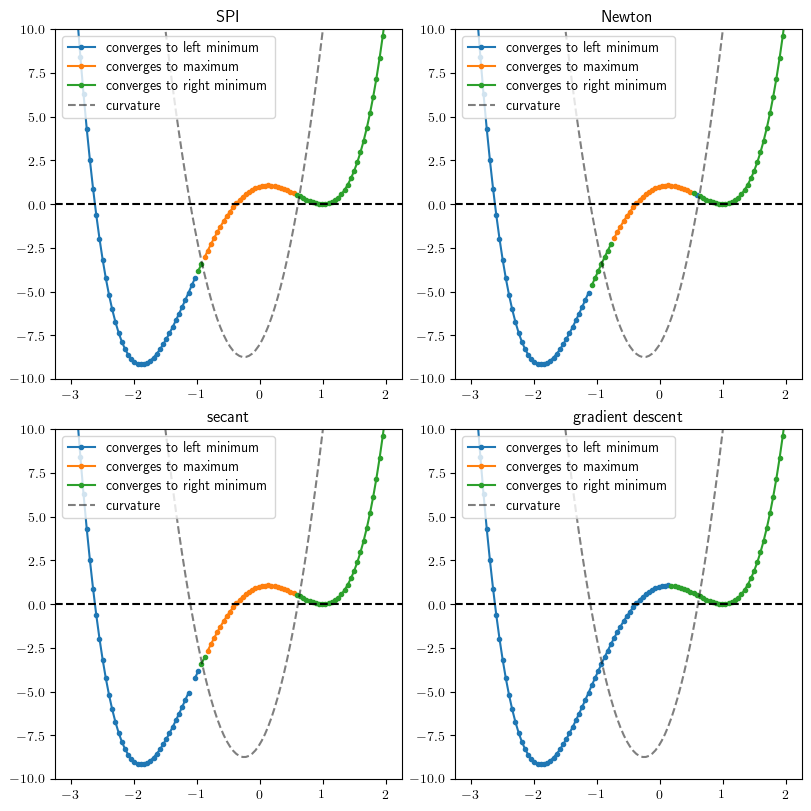

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 8))
axes = axes.flatten()

xs = np.linspace(-3, 2, 100)
f = quartic
df = quartic_derivative
d2f = quartic_hess
tol = 1e-8
step = 1e-3

stationary_points = (
    ("left minimum", -1.88278227),
    ("maximum", 0.13278222),
    ("right minimum", 1.0),
)

solutionss = [
    ("SPI", np.array([successive_parabolic_interpolation(f, x0, x0 + step, x0 + 2*step, tol) for x0 in xs])),
    ("Newton", np.array([newton(f, df, d2f, x0, tol) for x0 in xs])),
    ("secant", np.array([secant(f, df, x0, x0 + step, tol) for x0 in xs])),
    ("gradient descent", np.array([gradient_descent(f, df, x0, tol) for x0 in xs])),
]

for ax, (name, solutions) in zip(axes, solutionss):
    for label, p in stationary_points:
        ys = np.where(np.isclose(solutions, p) , xs, np.nan)
        ax.plot(ys, f(ys), '.-', label=f"converges to {label}") 
        ax.set_title(name)

for ax in axes:
    ax.plot(xs, d2f(xs), 'k--', alpha=0.5, label="curvature")
    ax.axhline(0, color='k', linestyle='--')
    ax.set_ylim(-10, 10)
    ax.legend()
    

In [45]:
def lennard_jones(x):
    x6 = 1/x/x
    x6 *= x6*x6
    return 4*x6*(x6-1)

def lennard_jones_gradient(x):
    x6 = 1/x/x
    x6 *= x6*x6
    return 24*x6*(1-2*x6)/x

def lennard_jones_hess(x):
    x2 = 1/x/x
    x6 = x2*x2*x2
    return 24*x6*x2*(26*x6-7)


def newton(f, df, d2f, x0, tol, force_minimum=False):
    """
    >>> newton(quintic, quintic_derivative, quintic_hess, 1.0, tol=1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16)  #doctest: +ELLIPSIS
    -0.6687403...
    >>> newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16, force_minimum=True)  #doctest: +ELLIPSIS
    0.6687403...
    """
    x1 = None
    
    if force_minimum:
        d2f_ = d2f  # avoid namespace clash & recursion in lambda
        d2f = lambda x: np.abs(d2f_(x))

    while relative_error(x0, x1) > tol:
        print(x0, df(x0), d2f(x0), -df(x0) / d2f(x0))
        x0 = x1 if x1 is not None else x0
        x1 = x0 - df(x0) / d2f(x0)
    print(x0, df(x0), d2f(x0), -df(x0) / d2f(x0))
    return x1


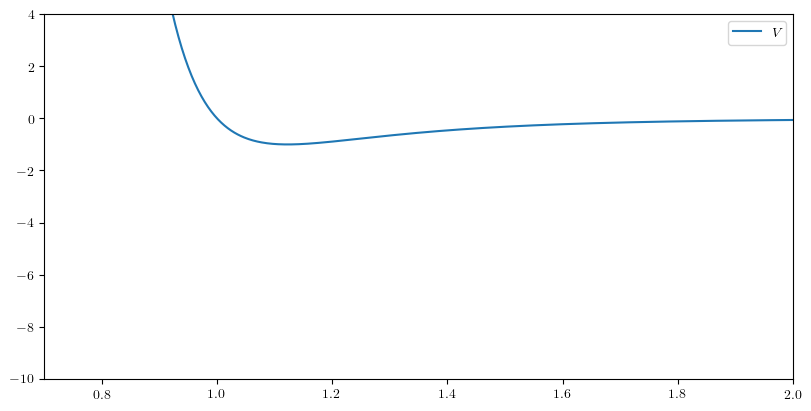

In [46]:
plt.rcParams["text.usetex"] = True
f = lennard_jones
df = lennard_jones_gradient
d2f = lennard_jones_hess

xs = np.linspace(0.1,2.0,1000)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8,4))
ax.plot(xs, f(xs), label='$V$')
# ax.plot(xs, df(xs), label=r'$\frac{d{V}}{d{r}}$')
# ax.plot(xs, d2f(xs), label=r'$\frac{d^{2}{V}}{d{r^{2}}}$')
# ax.axhline(0, color='k', linestyle='--')
ax.set_xlim(0.7,2)
ax.set_ylim(-10,4)
ax.legend()



In [47]:
x0 = 1.0
print("x0 dVdx d2Vdx2 dx")
newton(f, df, d2f, x0=x0, tol=1e-3)

x0 dVdx d2Vdx2 dx
1.0 -24.0 456.0 0.05263157894736842
1.0 -24.0 456.0 0.05263157894736842
1.0526315789473684 -7.880324891166253 192.85455451152822 0.04086149228430689
1.0934930712316753 -2.180667041831189 96.36728565767909 0.022628706691786134
1.1161217779234613 -0.38454586405964974 64.2746716295878 0.005982852254396121
1.1221046301778574 -0.020493591726608463 57.52964666192022 0.0003562266225454413


1.1224608568004029